<a href="https://colab.research.google.com/github/lorenzrossi/AMD-ComicsFaces/blob/main/AMD_Models_batch_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os import listdir
import pandas as pd
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tfk = tf.keras
tf.keras.backend.set_floatx("float64")


from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/ComicsFaces'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/X.pickle','rb'))
y = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/y.pickle','rb'))

pics_classes = ['comics','faces']

In [ ]:
number_of_classes = len(pics_classes)

In [ ]:
x_size, img_dim = X.shape[0], X.shape[1]

# rescale in [0,1]
X = tf.cast(X, tf.float32) / 255.0

# one hot encoding
depth = 1
y = tf.reshape(tf.one_hot(y, depth), shape = [x_size, depth])

In [ ]:
# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [ ]:
# Hyperparameters
epoch = 25 # n of epochs
batch = 64 # batch size

# Defining the loss
loss = keras.losses.BinaryCrossentropy()

# Defining the optimizer(s)
op_1 = Adam()
#op_2 = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/25)

In [ ]:
# Defining plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    # Loss plots
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','test'], fontsize = legend_size)

    # Accuracy plots
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    plt.show()

# TRAINING MODEL 1

In [ ]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_12 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_13 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

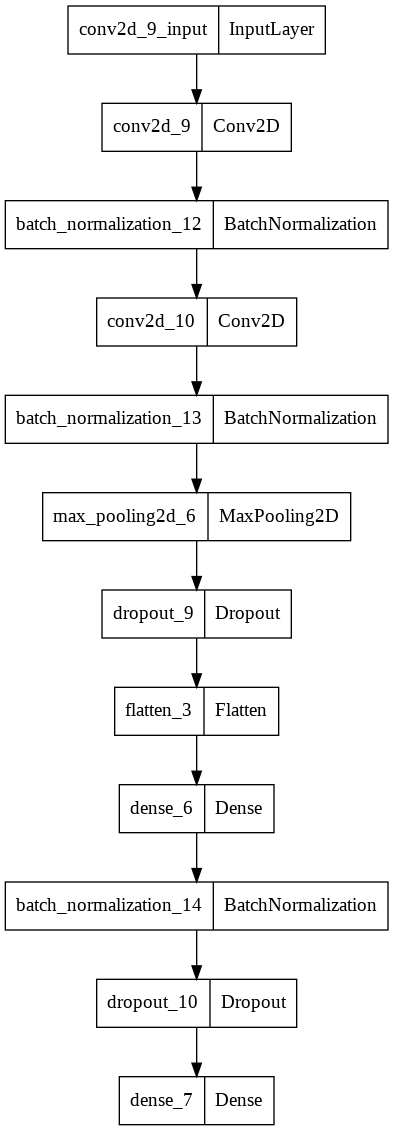

In [ ]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/25
200/200 [==============================] - 8s 34ms/step - loss: 0.0235 - binary_accuracy: 0.9922 - val_loss: 8.3016 - val_binary_accuracy: 0.4988
Epoch 2/25
200/200 [==============================] - 7s 33ms/step - loss: 0.0022 - binary_accuracy: 0.9995 - val_loss: 0.0100 - val_binary_accuracy: 0.9962
Epoch 3/25
200/200 [==============================] - 7s 33ms/step - loss: 0.0015 - binary_accuracy: 0.9997 - val_loss: 0.0179 - val_binary_accuracy: 0.9962
Epoch 4/25
200/200 [==============================] - 7s 33ms/step - loss: 6.0565e-04 - binary_accuracy: 0.9999 - val_loss: 0.0034 - val_binary_accuracy: 0.9984
Epoch 5/25
200/200 [==============================] - 7s 33ms/step - loss: 5.5681e-04 - binary_accuracy: 0.9998 - val_loss: 5.9164e-04 - val_binary_accuracy: 0.9997
Epoch 6/25
200/200 [==============================] - 7s 33ms/step - loss: 1.0570e-04 - binary_accuracy: 1.0000 - val_loss: 1.4799e-04 - val_binary_accuracy: 1.0000
Epoch 7/25
200/200 [==================

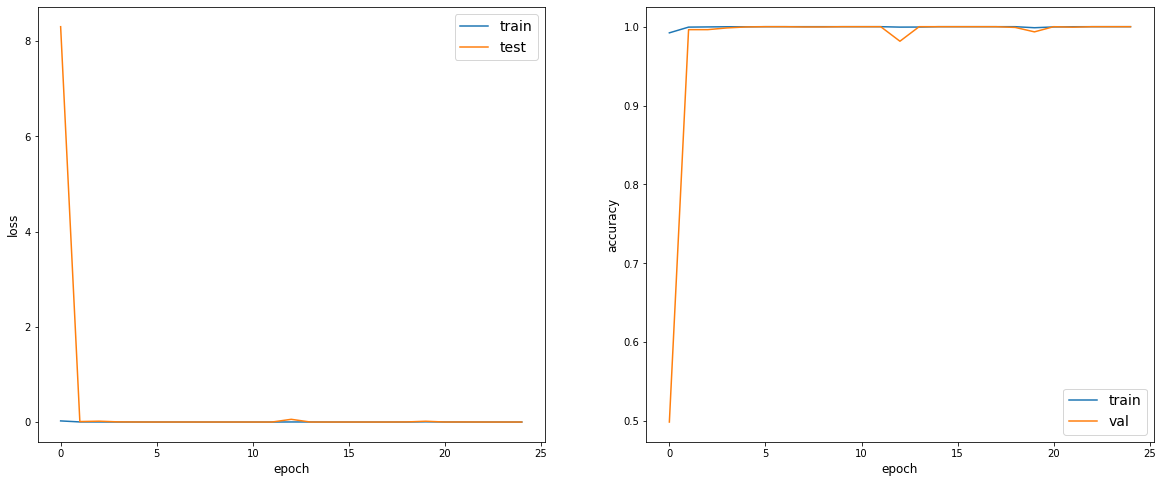

125/125 [==============================] - 1s 7ms/step - loss: 1.1776e-04 - binary_accuracy: 1.0000
test loss, test acc: [0.00011775811214895697, 1.0]


In [ ]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

# TRAINING MODEL 2

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_15 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_16 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

Epoch 1/25
200/200 [==============================] - 9s 41ms/step - loss: 0.0181 - binary_accuracy: 0.9936 - val_loss: 1.6802 - val_binary_accuracy: 0.5012
Epoch 2/25
200/200 [==============================] - 8s 40ms/step - loss: 0.0030 - binary_accuracy: 0.9993 - val_loss: 0.5586 - val_binary_accuracy: 0.7284
Epoch 3/25
200/200 [==============================] - 8s 40ms/step - loss: 8.5513e-04 - binary_accuracy: 0.9998 - val_loss: 0.5117 - val_binary_accuracy: 0.9225
Epoch 4/25
200/200 [==============================] - 8s 41ms/step - loss: 0.0011 - binary_accuracy: 0.9998 - val_loss: 4.6847e-04 - val_binary_accuracy: 1.0000
Epoch 5/25
200/200 [==============================] - 8s 41ms/step - loss: 5.9242e-04 - binary_accuracy: 0.9998 - val_loss: 0.0110 - val_binary_accuracy: 0.9969
Epoch 6/25
200/200 [==============================] - 8s 40ms/step - loss: 0.0011 - binary_accuracy: 0.9995 - val_loss: 0.0183 - val_binary_accuracy: 0.9962
Epoch 7/25
200/200 [==========================

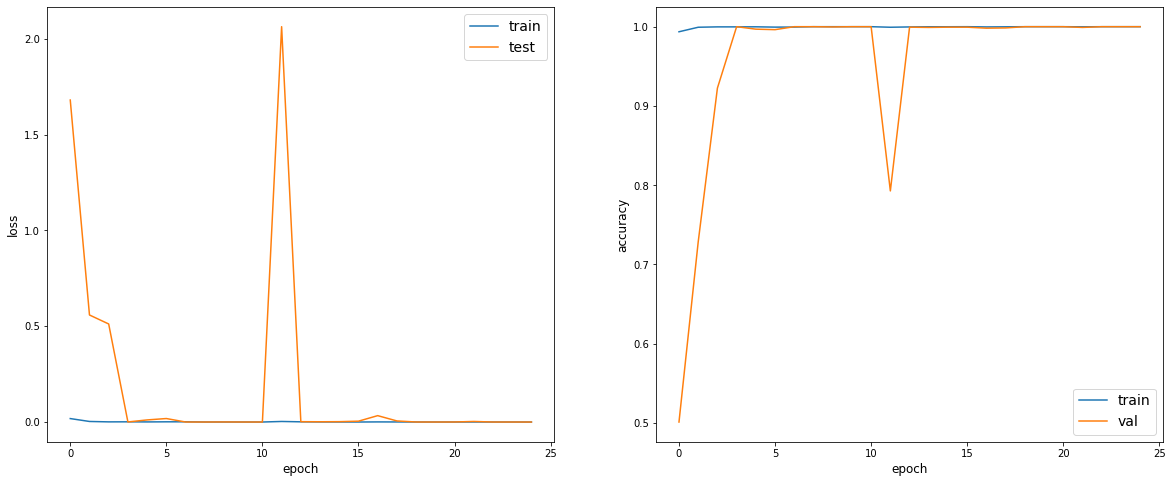

125/125 [==============================] - 1s 8ms/step - loss: 2.8700e-05 - binary_accuracy: 1.0000
test loss, test acc: [2.870038538692462e-05, 1.0]


In [ ]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

# TRAINING MODEL 3

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_19 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_20 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

Epoch 1/25
200/200 [==============================] - 11s 48ms/step - loss: 0.0193 - binary_accuracy: 0.9931 - val_loss: 1.8128 - val_binary_accuracy: 0.4988
Epoch 2/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0050 - binary_accuracy: 0.9987 - val_loss: 3.0133 - val_binary_accuracy: 0.4988
Epoch 3/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - val_loss: 0.1068 - val_binary_accuracy: 0.9762
Epoch 4/25
200/200 [==============================] - 9s 45ms/step - loss: 9.8362e-04 - binary_accuracy: 0.9998 - val_loss: 0.0145 - val_binary_accuracy: 0.9956
Epoch 5/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - val_loss: 0.0041 - val_binary_accuracy: 0.9991
Epoch 6/25
200/200 [==============================] - 9s 45ms/step - loss: 5.0825e-04 - binary_accuracy: 0.9998 - val_loss: 0.0032 - val_binary_accuracy: 0.9988
Epoch 7/25
200/200 [=============================

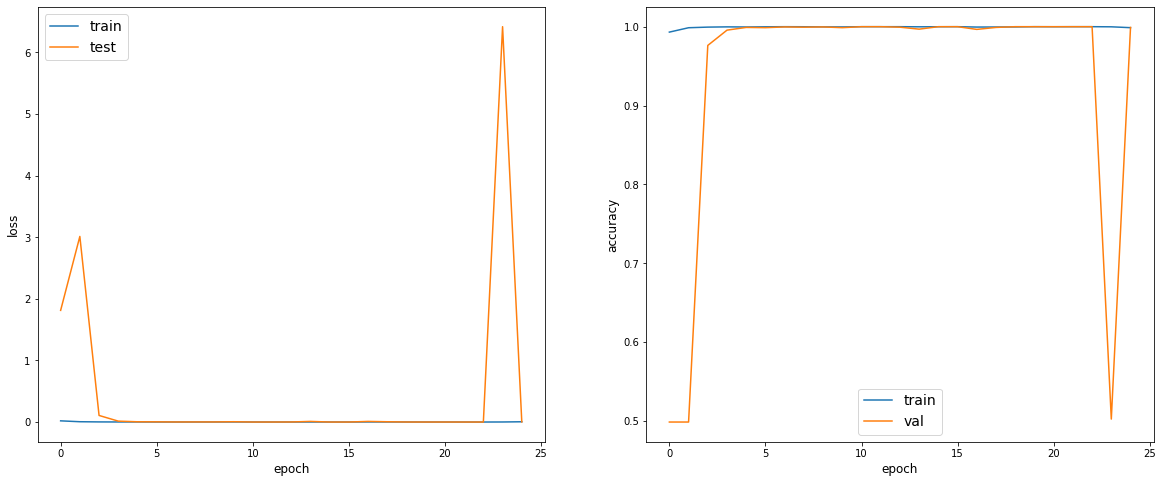

125/125 [==============================] - 1s 8ms/step - loss: 0.0049 - binary_accuracy: 0.9982
test loss, test acc: [0.004855204041432488, 0.99825]


In [ ]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)